In [31]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import colorsys
from math import pi, ceil, floor, cos, sin
import glob
import pandas as pd
import os

from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

sys.path.insert(0, './segmentation_methods')

from ipynb.fs.full.general_functions import UNET_VALIDATION, HSV_VALIDATION, NO_VALIDATION
import ipynb.fs.full.methods_names as methods

_root       = "./blood_samples/samples/"
results_dir = "./segmented/"

Errors: 0


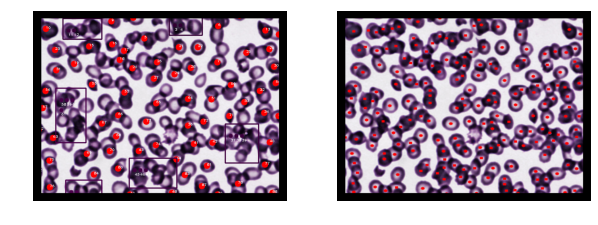

In [32]:
def not_yellow_random_color():
    color = np.random.randint(1,256, size=3)
    hsv = colorsys.rgb_to_hsv(color[0],color[1],color[2])
    if 30 <= hsv[0] <= 90:
        return not_yellow_random_color()
    return tuple((int(color[0]),int(color[1]),int(color[2])))
    

def compare_parasites_markers(manual, img):
    
    if type(manual) == str:
        manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
        manual = cv2.resize(manual,(640,480))
        
    if type(img) == str:
        img = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(640,480))
        
    
    #faz um retangulo ao redor da imagem para remover as marcacoes proximas a borda
    manual = cv2.rectangle(manual, (0,0), (640,480), (0,0,0), 40)
    img    = cv2.rectangle(img, (0,0), (640,480), (0,0,0), 40)
        
    
    manual = manual.copy()
    img = img.copy()
    
    #encontra as marcações relacionadas
    img_mask    = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    manual_mask = cv2.inRange(cv2.cvtColor(manual, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    
    
    total_count1, _, stats1, centroids1 = cv2.connectedComponentsWithStats(img_mask, 4, cv2.CV_32S)
    total_count2, _, stats2, centroids2 = cv2.connectedComponentsWithStats(manual_mask, 4, cv2.CV_32S)
    
    for i in range(total_count1):
        if stats1[i, cv2.CC_STAT_AREA] > 1000:
            continue
        for y in range(total_count2):
            if stats2[y, cv2.CC_STAT_AREA] > 1000:
                continue
            
            dist = np.linalg.norm(centroids1[i]-centroids2[y])
            if dist < 30:
                color = not_yellow_random_color()
                cX, cY = centroids1[i]
                cv2.circle(img, (int(cX),int(cY)), 10, color, -1)
                cX, cY = centroids2[y]
                cv2.circle(manual, (int(cX),int(cY)), 10, color, -1)
                
                
    #conta quantas marcações amarelas sobraram
    img_mask    = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    manual_mask = cv2.inRange(cv2.cvtColor(manual, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    errors = 0
    
    total_count1, _, stats1, centroids1 = cv2.connectedComponentsWithStats(img_mask, 4, cv2.CV_32S)
    total_count2, _, stats2, centroids2 = cv2.connectedComponentsWithStats(manual_mask, 4, cv2.CV_32S)
    
    
#     plt.imshow(img_mask)
#     plt.show()
#     plt.imshow(manual_mask)
#     plt.show()
    errors = total_count1 + total_count2 - 2
    
    return errors, img, manual


if __name__ == "__main__":
    #manual = "./blood_samples/ground_truth/blood_smear_1.JPG"
    #manual = "./blood_samples/ground_truth/blood_smear_7.JPG"
    fimg = "df3d98b9-3dd7-4107-8d4a-ae1b7f247793.png"
    manual = "./verification-images/ground_truth/%s" % fimg
    manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
    manual = cv2.resize(manual,(640,480))
    #img = "./segmented/hsv/blood_smear_1_otsu.png"
    img = "./verification-images/malaria-app/%s" % fimg
    img    = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
    errors, img, manual = compare_parasites_markers(manual, img)

    print("Errors:", errors)
    fig, ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(img)
    ax[1].imshow(manual)
    plt.show()

{'true_positive': 113, 'true_negative': 0, 'false_positive': 0, 'false_negative': 84, 'cells_qtd': 113, 'ground_truth_qtd': 199}
Errors: 84


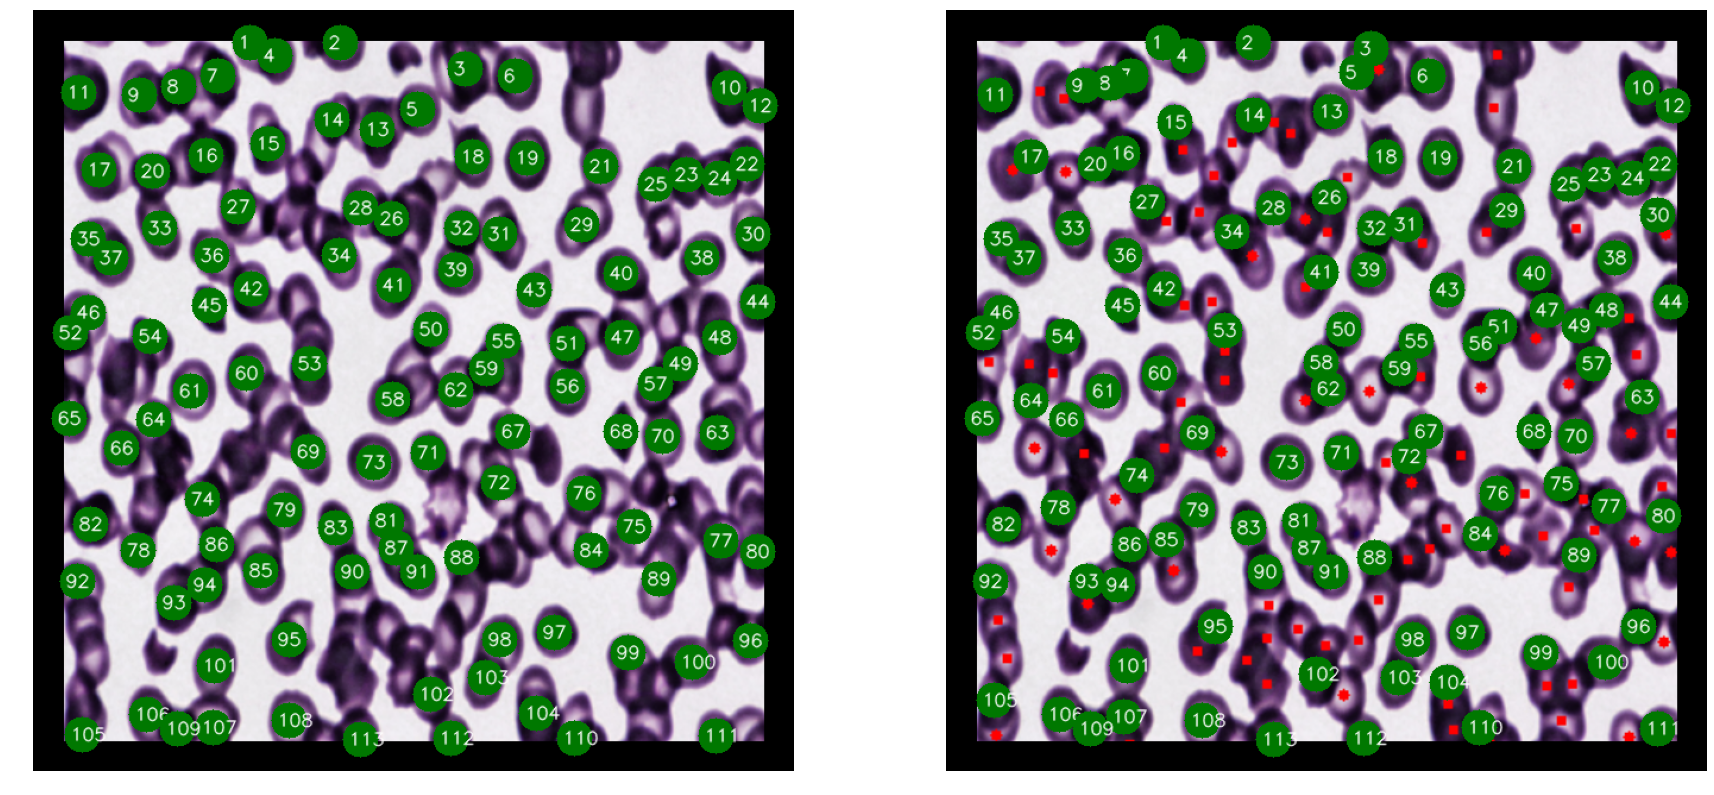

In [33]:


def get_img(name):
    return cv2.imread(name,1)
    
    
def not_red_random_color():
    color = np.random.randint(1,256, size=3)
    color[0] = 100
    if (color[1] < 100 and color[2] < 100):
        return not_red_random_color()
    elif (color[1] > 230 and color[2] > 230):
        return not_red_random_color()
    else:
        return tuple((int(color[0]),int(color[1]),int(color[2])))
    



def compare_markers(manual, img):
    
    circle_size = 15
    distance_range = 40
    text_x_adjust = 10
    text_y_adjust = 5
    
    if type(manual) == str:
        manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
        manual = cv2.resize(manual,(640,640))
        
    if type(img) == str:
        img = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(640,640))
        
    manual = manual.copy()
    img = img.copy()
    
    
    #faz um retangulo ao redor da imagem para remover as marcacoes proximas a borda
    manual = cv2.rectangle(manual, (0,0), (640,640), (0,0,0), 50)
    img    = cv2.rectangle(img, (0,0), (640,640), (0,0,0), 50)
    
    
    true_positive = 0
    true_negative = 0 #nao sera usado
    false_positive = 0
    false_negative = 0
    
    errors = 0
    total = 0
    manual_total = 0
    max_area = 300 #despreza as marcações das bordas
    min_area = 5
    
    #procura por todas as marcacoes que estejam em posicoes similares nas duas imagens
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    #dilata para corrigir erros de contagem
    kernel = np.ones((5, 5), np.uint8) 
    mask = cv2.dilate(mask, kernel, iterations=1)
    #mask = cv2.erode(mask,np.ones((5,5)))
    total_count, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    total = total_count - 1
    centroids = np.delete(centroids, 0, 0)
    
        
    hsv = cv2.cvtColor(manual,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    #mask = cv2.erode(mask,np.ones((5,5)))
    manual_count, _, _, manual_centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    manual_total += manual_count -1
    manual_centroids = np.delete(manual_centroids, 0, 0)
    
    
    #print("total", total, "manual_total", manual_total)
    
    
    yCount = 0
    #das celulas restantes procuro a marcação relacionada
    for m_c in manual_centroids:
        i = 0
        list_distances = []
        list_ids       = []
        list_indexes   = []
        
        #verifica pra cada uma das posicoes encontradas na outra imagem
        real_index = -1
        for c in centroids:
            real_index += 1
            dist = np.linalg.norm(c-m_c)
            #se atende aos requisitos de tamanho e distancia
            if dist < distance_range: # and stats[i, cv2.CC_STAT_AREA] < max_area:
                #se sim, adiciona na lista de candidatos
                list_distances.append(dist)
                list_ids.append(c)
                list_indexes.append(real_index)
        
        #seleciona o elemento que teve a menor distancia
        if (len(list_distances) > 0):
            _min = min(list_distances)
            list_index = list_distances.index(_min)
            c = list_ids[list_index]
            real_index = list_indexes[list_index]

            #pinta
            yCount += 1
            cX, cY = m_c
            color = (0,120,0)#not_red_random_color()
            cv2.circle(manual, (int(cX),int(cY)), circle_size, color, -1)
            cv2.putText(manual, str(yCount), (int(cX)-text_x_adjust,int(cY)+text_y_adjust), 
                        cv2.FONT_HERSHEY_SIMPLEX , 0.5, (255,255,255), 1, cv2.LINE_AA) 
            cX, cY = c
            cv2.circle(img,    (int(cX),int(cY)), circle_size, color, -1)
            cv2.putText(img, str(yCount), (int(cX)-text_x_adjust,int(cY)+text_y_adjust), 
                        cv2.FONT_HERSHEY_SIMPLEX , 0.5, (255,255,255), 1, cv2.LINE_AA) 
            i += 1
            
            #remove dos centroids os que ja foram utilizados
            centroids = np.delete(centroids, real_index, 0)
            true_positive += 1
            
#             if yCount == 2:
#                 import pdb;pdb.set_trace();
#                 plt.imshow(img)
#                 plt.show()
    
    #conta as células que estao agrupadas
    #relacionando com as posicoes na contagem manual
    
    
    false_positive = total - true_positive
    
    
    def has_more_groups(img, color):
        mask = cv2.inRange(img, (color,0,color), (255,0,255))
        #maior do que 50000 porque em algumas imagens foi encontrado esse tom de roxo
        return np.sum(mask) > 50000

    color = 50

    
    while (has_more_groups(img, color)):
        #encontra a caixa
        #aqui ele cria uma mascara apenas com o retangulo
        #sem os circulos roxos de dentro
        mask = cv2.inRange(img, (color+2,0,color+2), (color+2,0,color+2))
        
        
        #preenche as bordas falhadas do retangulo
        image = img_as_bool(mask)
        out = ndi.distance_transform_edt(~image)
        out = out < 0.05 * out.max()
        out = morphology.skeletonize(out)
        out = morphology.binary_dilation(out) #, morphology.footprints) #morphology.selem.disk(1)
        out = segmentation.clear_border(out)
        out = out | image
        mask[out] = 255
        
        
        
        #encontra o retangulo que envolve as celulas
        cnts, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        max_area = 0
        sel = 0
        for c in range(len(cnts)):
            area = cv2.contourArea(cnts[c])
            if max_area < area:
                max_area = area
                sel = c
        x,y,w,h = cv2.boundingRect(cnts[sel])
        #cv2.rectangle(mask, (x,y), (x+w,y+h), 255, 3)
            
        
        #agora sim ele vai pegar a posicao do retangulo e pegar todos os circulos sem pegar o retangulo
        #contagem das celulas encontradas pelo algoritmo
        #conta as celulas da cor da caixa
        mask_cells = cv2.inRange(img, (color,0,color), (color,0,color))
        box_count, _, _, _ = cv2.connectedComponentsWithStats(mask_cells, 4, cv2.CV_32S)
        box_count = box_count-1
        #conta as celulas vermelhas ainda dentro da caixa
        img_cut = img[y:y+h,x:x+w]
        hsv = cv2.cvtColor(img_cut,cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
        num, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
        
        
        cv2.rectangle(img, (x,y),(x+30,y+30), (255,255,0), -1)
        cv2.putText(img, str(box_count), (x+5,y+20), 
                    cv2.FONT_HERSHEY_SIMPLEX , 0.7, (0,0,0), 2, cv2.LINE_AA) 
        
        cell_count = 0
#         for i in range(num):
#             stat = stats[i]
#             if (min_area < stat[cv2.CC_STAT_AREA] < max_area):
#                 center = centroids[i]
#                 cell_count += 1
#                 #marca as celulas que foram contadas na imagem original
#                 cX, cY = center
#                 cv2.circle(img, (x+int(cX),y+int(cY)), circle_size, (0,255,0), -1)
#                 cv2.putText(img, str(cell_count), (x+int(cX)-text_x_adjust,y+int(cY)+text_y_adjust), 
#                         cv2.FONT_HERSHEY_SIMPLEX , 0.5, (255,255,255), 1, cv2.LINE_AA)
        cell_count += box_count
        
        #conta as celulas dentro da caixa na contagem manual
        cut = manual[y:y+h,x:x+w]
        hsv = cv2.cvtColor(cut,cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
        num, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
        max_area = 300
        min_area = 5
        manual_count = 0
        for i in range(num):
            if i <= box_count:
                stat = stats[i]
                if (min_area < stat[cv2.CC_STAT_AREA] < max_area):
                    manual_count += 1
                    center = centroids[i]
                    #marca as celulas que foram contadas na imagem original
                    cX, cY = center
                    cv2.circle(manual, (x+int(cX),y+int(cY)), circle_size, (0,200,0), -1)
                    cv2.putText(manual, str(manual_count), (x+int(cX)-text_x_adjust,y+int(cY)+text_y_adjust), 
                            cv2.FONT_HERSHEY_SIMPLEX , 0.5, (0,0,0), 1, cv2.LINE_AA) 
                    true_positive += 1
        
        
        mask_cells = mask_cells[y:y+h,x:x+w]
        
        total        += cell_count
        #manual_total += manual_count
        #print("count",cell_count, "manual",manual_count)
        
        err = cell_count - manual_count
        if (err > 0):
            false_positive += abs(err)
        else:
            false_negative += abs(err)
        errors += abs(err)
        
        color += 5

        
    #conta quantas marcacoes vermelhas sobraram em ambas
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    total_error, _, _, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    total_error -= 1
    #false_positive += total_error
        
    hsv = cv2.cvtColor(manual,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    manual_error, _, _, manual_centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    manual_error -= 1
    false_negative += manual_error
    
    errors += total_error + manual_error
        
    return errors, img, manual, {"true_positive":true_positive, 
                                 "true_negative":true_negative,
                                 "false_positive":false_positive, 
                                 "false_negative":false_negative,
                                 "cells_qtd": total,
                                 "ground_truth_qtd": manual_total}


if __name__ == "__main__":
    
    fimg = "df3d98b9-3dd7-4107-8d4a-ae1b7f247793.png"
    #fimg = "e3a4b3e7-9500-4b6c-a402-b6d3f45e714b.png"
    #fimg = "edd09b2e-2673-4405-8ac0-e476e003e96a.png"
    #fimg = "ef1a9020-5e45-450d-a237-165114308592.png"
    #fimg = "df4fd610-fa16-45ca-b3a3-a25a14e5c4e9.png"
    #fimg = "e640ae51-cbf1-4a84-b7cf-d38b17f59c2f.png"
    
    #87 semar_8
    #95 manual
    #manual = cv2.imread("./blood_samples/ground_truth/blood_smear_8.JPG"
    manual = "./verification-images/ground_truth/%s" % fimg
    #img    = "./segmented/oliveira/blood_smear_8.png"
    #img    = "./verification-images/malaria-app/%s" % fimg
    img    = "./verification-images/cell_pose/%s" % fimg
    #img    = "./segmented/standalone/Yolo 512 new dataset/%s" % fimg
    #img    = "./segmented/standalone/OTSU/%s" % fimg
    
    
    errors, img, manual, st = compare_markers(manual, img)

    
    print(st)
    print("Errors:", errors)
    fig, ax = plt.subplots(ncols=2, figsize=(30,30))
    ax[0].imshow(img)
    ax[1].imshow(manual)
    plt.show()

In [34]:
def getManualCount(name):
    return {"method":"Manual", "path":name, "time":0}


def getOriginalCount(original_result_directory, file_name):
    image_path = original_result_directory + file_name
    
    return {"method"  :"Original",
            "time"    : 0,
            "path"    :image_path.replace("../","./")}

def getCellPoseCount(cell_pose_directory,file_name):
    image_path = cell_pose_directory + file_name
    return {"method"  :"Cell Pose",
            "time"    : 0,
            "path"    :image_path.replace("../","./")}

def getProjectCount(name,method):
    result_directory = "./segmented/myresults/standalone/"
    name = result_directory + name.replace(".png","_result.txt").replace(".jpg","_result.txt")
    
    f = open(name,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    ret = []
    for i in range(1,len(lines),1):
        
        data = lines[i].split("\t")
        if len(data) > 1:

            #se for para ler apenas um metodo especifico or ler os resultados de todos os metodos
            #metodos(de segmentacao)
            if method != None and data[0].strip() == method or method == None:
                ret.append({
                    'method'  : data[0].strip(),
                    'time'    : float(data[4].strip().replace("s","")),
                    'path'    : data[5].strip().replace("../","./")
                })
    return ret


def add_to_samples(samples,values):
    for key in values.keys():
        samples[key].append(values[key])
    
    if "cells_error" not in values.keys():
        samples['cells_error'].append(-1)
    if "infection_error" not in values.keys():
        samples['infection_error'].append(-1)
    if ("true_positive" not in values.keys()):
        samples["true_positive"].append(-1)
        samples["true_negative"].append(-1)
        samples["false_positive"].append(-1)
        samples["false_negative"].append(-1)
        samples["cells_qtd"].append(-1)
        samples["ground_truth_qtd"].append(-1)
        samples["acc"].append(-1)
        samples["precision"].append(-1)
        samples["recall"].append(-1)
        samples["f1-score"].append(-1)
    else:
        #(TP+TN)/(TP+TN+FP+FN)
        acc = (values["true_positive"]+values["true_negative"])/(values["true_positive"]+values["true_negative"]+values["false_positive"]+values["false_negative"])
        samples["acc"].append(acc)
        precision = values["true_positive"]/(values["true_positive"]+values["false_positive"])
        samples["precision"].append(precision)
        recall = values["true_positive"]/(values["true_positive"]+values["false_negative"])
        samples["recall"].append(recall)
        f1 = (2*precision*recall)/(precision+recall)
        samples["f1-score"].append(f1)
    
    
    
def read_result_data(results_dir,method=None):
    
    gt_directory = "./verification-images/ground_truth/"

    samples = {"sample":[],
               "method":[],
               "time":[],
               "path":[],
               "infection_error":[],
               "cells_error":[],
               "true_positive":[],
               "true_negative":[], #nao usado
               "false_positive":[],
               "false_negative":[],
               "cells_qtd":[],
               "ground_truth_qtd":[],
               "acc":[],
               "precision":[],
               "recall":[],
               "f1-score":[]}

    qtd = 0
    for file in glob.glob(gt_directory+"*.png"):
        qtd += 1
        
        
        #nome da amostra
        file_name = os.path.basename(file)
        file = file.replace("\\","/").lower()
        name = file
        sample_name = name.replace(gt_directory,"")
        samples['sample'].append(sample_name)

        #adiciona os dados do Ground truth a base
        manual = getManualCount(file)
        add_to_samples(samples,manual)
        
        #le os dados obtidos pelo projeto
        data = getProjectCount(file_name,  method)
        for dt in data:
            #adiciona na base
            samples['sample'].append(sample_name)
            print("reading",dt['path'])
            dt['cells_error'], _, _, st = compare_markers(file, dt['path'])
            dt['infection_error'], _, _ = compare_parasites_markers(file, dt['path'])
            dt['cells_qtd']           = st['cells_qtd']
            dt['ground_truth_qtd']    = st['ground_truth_qtd']
            dt["true_positive"]       = st["true_positive"]
            dt["true_negative"]       = st["true_negative"]
            dt["false_positive"]      = st["false_positive"]
            dt["false_negative"]      = st["false_negative"]


            add_to_samples(samples,dt)

        
        #le os dados do projeto original
        #orig = getOriginalCount("./segmented/oliveira", name)
        orig = getOriginalCount("./verification-images/malaria-app/", file_name)
        
        samples['sample'].append(sample_name)
        print("reading",orig['path'])
        orig['cells_error'], _, _, st = compare_markers(file, orig['path'])
        orig['infection_error'], _, _ = compare_parasites_markers(file, orig['path'])
        orig['cells_qtd']        = st['cells_qtd']
        orig['ground_truth_qtd'] = st['ground_truth_qtd']
        orig["true_positive"]    = st["true_positive"]
        orig["true_negative"]    = st["true_negative"]
        orig["false_positive"]   = st["false_positive"]
        orig["false_negative"]   = st["false_negative"]
        #adiciona na base
        add_to_samples(samples,orig)
        
        #le os resultados do cellpose
        cell_p = getCellPoseCount("./verification-images/cell_pose/",file_name)
        samples['sample'].append(sample_name)
        print("reading",cell_p['path'])
        cell_p['cells_error'], _, _, st = compare_markers(file, cell_p['path'])
        cell_p['infection_error'], _, _ = compare_parasites_markers(file, cell_p['path'])
        cell_p['cells_qtd']        = st['cells_qtd']
        cell_p['ground_truth_qtd'] = st['ground_truth_qtd']
        cell_p["true_positive"]    = st["true_positive"]
        cell_p["true_negative"]    = st["true_negative"]
        cell_p["false_positive"]   = st["false_positive"]
        cell_p["false_negative"]   = st["false_negative"]
        add_to_samples(samples,cell_p)

    try:
        samples = pd.DataFrame(data=samples)
    except:
        for key in samples:
            print (key," len:", len(samples[key]) )
    return samples

if __name__ == "__main__":
    samples = read_result_data(results_dir, method=None)
    print ("end")

reading ./segmented/standalone/OTSU/dec61ae1-5037-4c3a-8952-15371becca7d.png
reading ./segmented/standalone/OTSU w-out blur/dec61ae1-5037-4c3a-8952-15371becca7d.png
reading ./segmented/standalone/Watershed/dec61ae1-5037-4c3a-8952-15371becca7d.png
reading ./segmented/standalone/Hough Circles/dec61ae1-5037-4c3a-8952-15371becca7d.png
reading ./segmented/standalone/OTSU and Hough method 1 break/dec61ae1-5037-4c3a-8952-15371becca7d.png
reading ./segmented/standalone/OTSU and Hough method 2 merge/dec61ae1-5037-4c3a-8952-15371becca7d.png
reading ./segmented/standalone/U-net 256 new dataset/dec61ae1-5037-4c3a-8952-15371becca7d.png
reading ./segmented/standalone/Yolo 512 new dataset/dec61ae1-5037-4c3a-8952-15371becca7d.png
reading ./segmented/standalone/RCNNv4 1024/dec61ae1-5037-4c3a-8952-15371becca7d.png
reading ./segmented/standalone/RCNNv5n 512/dec61ae1-5037-4c3a-8952-15371becca7d.png
reading ./segmented/standalone/Yolo 416 new dataset/dec61ae1-5037-4c3a-8952-15371becca7d.png
reading ./segme

reading ./verification-images/cell_pose/e02301ac-68f7-4daf-b2ba-254b917f1cca.png
reading ./segmented/standalone/OTSU/e0ff3476-226f-4125-b182-8e524d5503dd.png
reading ./segmented/standalone/OTSU w-out blur/e0ff3476-226f-4125-b182-8e524d5503dd.png
reading ./segmented/standalone/Watershed/e0ff3476-226f-4125-b182-8e524d5503dd.png
reading ./segmented/standalone/Hough Circles/e0ff3476-226f-4125-b182-8e524d5503dd.png
reading ./segmented/standalone/OTSU and Hough method 1 break/e0ff3476-226f-4125-b182-8e524d5503dd.png
reading ./segmented/standalone/OTSU and Hough method 2 merge/e0ff3476-226f-4125-b182-8e524d5503dd.png
reading ./segmented/standalone/U-net 256 new dataset/e0ff3476-226f-4125-b182-8e524d5503dd.png
reading ./segmented/standalone/Yolo 512 new dataset/e0ff3476-226f-4125-b182-8e524d5503dd.png
reading ./segmented/standalone/RCNNv4 1024/e0ff3476-226f-4125-b182-8e524d5503dd.png
reading ./segmented/standalone/RCNNv5n 512/e0ff3476-226f-4125-b182-8e524d5503dd.png
reading ./segmented/standal

reading ./segmented/standalone/RCNNv4 1024/e26b88c6-5884-4b5c-94d7-ad780379c8ad.png
reading ./segmented/standalone/RCNNv5n 512/e26b88c6-5884-4b5c-94d7-ad780379c8ad.png
reading ./segmented/standalone/Yolo 416 new dataset/e26b88c6-5884-4b5c-94d7-ad780379c8ad.png
reading ./segmented/standalone/RCNNv6n 256/e26b88c6-5884-4b5c-94d7-ad780379c8ad.png
reading ./verification-images/malaria-app/e26b88c6-5884-4b5c-94d7-ad780379c8ad.png
reading ./verification-images/cell_pose/e26b88c6-5884-4b5c-94d7-ad780379c8ad.png
reading ./segmented/standalone/OTSU/e36cb882-c6d0-4467-812e-d18c169a9a47.png
reading ./segmented/standalone/OTSU w-out blur/e36cb882-c6d0-4467-812e-d18c169a9a47.png
reading ./segmented/standalone/Watershed/e36cb882-c6d0-4467-812e-d18c169a9a47.png
reading ./segmented/standalone/Hough Circles/e36cb882-c6d0-4467-812e-d18c169a9a47.png
reading ./segmented/standalone/OTSU and Hough method 1 break/e36cb882-c6d0-4467-812e-d18c169a9a47.png
reading ./segmented/standalone/OTSU and Hough method 2 m

reading ./segmented/standalone/OTSU and Hough method 1 break/e474a20b-2769-48f1-a520-4f6ef5a0dbf5.png
reading ./segmented/standalone/OTSU and Hough method 2 merge/e474a20b-2769-48f1-a520-4f6ef5a0dbf5.png
reading ./segmented/standalone/U-net 256 new dataset/e474a20b-2769-48f1-a520-4f6ef5a0dbf5.png
reading ./segmented/standalone/Yolo 512 new dataset/e474a20b-2769-48f1-a520-4f6ef5a0dbf5.png
reading ./segmented/standalone/RCNNv4 1024/e474a20b-2769-48f1-a520-4f6ef5a0dbf5.png
reading ./segmented/standalone/RCNNv5n 512/e474a20b-2769-48f1-a520-4f6ef5a0dbf5.png
reading ./segmented/standalone/Yolo 416 new dataset/e474a20b-2769-48f1-a520-4f6ef5a0dbf5.png
reading ./segmented/standalone/RCNNv6n 256/e474a20b-2769-48f1-a520-4f6ef5a0dbf5.png
reading ./verification-images/malaria-app/e474a20b-2769-48f1-a520-4f6ef5a0dbf5.png
reading ./verification-images/cell_pose/e474a20b-2769-48f1-a520-4f6ef5a0dbf5.png
reading ./segmented/standalone/OTSU/e4827c85-311a-4df1-89c2-99dad0c3558c.png
reading ./segmented/sta

reading ./segmented/standalone/OTSU/e683144c-0465-43a2-86b1-3cf52599d5e0.png
reading ./segmented/standalone/OTSU w-out blur/e683144c-0465-43a2-86b1-3cf52599d5e0.png
reading ./segmented/standalone/Watershed/e683144c-0465-43a2-86b1-3cf52599d5e0.png
reading ./segmented/standalone/Hough Circles/e683144c-0465-43a2-86b1-3cf52599d5e0.png
reading ./segmented/standalone/OTSU and Hough method 1 break/e683144c-0465-43a2-86b1-3cf52599d5e0.png
reading ./segmented/standalone/OTSU and Hough method 2 merge/e683144c-0465-43a2-86b1-3cf52599d5e0.png
reading ./segmented/standalone/U-net 256 new dataset/e683144c-0465-43a2-86b1-3cf52599d5e0.png
reading ./segmented/standalone/Yolo 512 new dataset/e683144c-0465-43a2-86b1-3cf52599d5e0.png
reading ./segmented/standalone/RCNNv4 1024/e683144c-0465-43a2-86b1-3cf52599d5e0.png
reading ./segmented/standalone/RCNNv5n 512/e683144c-0465-43a2-86b1-3cf52599d5e0.png
reading ./segmented/standalone/Yolo 416 new dataset/e683144c-0465-43a2-86b1-3cf52599d5e0.png
reading ./segme

reading ./verification-images/malaria-app/e81bf478-27ff-458c-ac30-9e1f8480bc5c.png
reading ./verification-images/cell_pose/e81bf478-27ff-458c-ac30-9e1f8480bc5c.png
reading ./segmented/standalone/OTSU/e871f52c-77a6-4813-80d4-95bd97985f1a.png
reading ./segmented/standalone/OTSU w-out blur/e871f52c-77a6-4813-80d4-95bd97985f1a.png
reading ./segmented/standalone/Watershed/e871f52c-77a6-4813-80d4-95bd97985f1a.png
reading ./segmented/standalone/Hough Circles/e871f52c-77a6-4813-80d4-95bd97985f1a.png
reading ./segmented/standalone/OTSU and Hough method 1 break/e871f52c-77a6-4813-80d4-95bd97985f1a.png
reading ./segmented/standalone/OTSU and Hough method 2 merge/e871f52c-77a6-4813-80d4-95bd97985f1a.png
reading ./segmented/standalone/U-net 256 new dataset/e871f52c-77a6-4813-80d4-95bd97985f1a.png
reading ./segmented/standalone/Yolo 512 new dataset/e871f52c-77a6-4813-80d4-95bd97985f1a.png
reading ./segmented/standalone/RCNNv4 1024/e871f52c-77a6-4813-80d4-95bd97985f1a.png
reading ./segmented/standalo

reading ./segmented/standalone/Yolo 512 new dataset/eaf4b781-b3aa-41ce-8c5e-287979b4e15a.png
reading ./segmented/standalone/RCNNv4 1024/eaf4b781-b3aa-41ce-8c5e-287979b4e15a.png
reading ./segmented/standalone/RCNNv5n 512/eaf4b781-b3aa-41ce-8c5e-287979b4e15a.png
reading ./segmented/standalone/Yolo 416 new dataset/eaf4b781-b3aa-41ce-8c5e-287979b4e15a.png
reading ./segmented/standalone/RCNNv6n 256/eaf4b781-b3aa-41ce-8c5e-287979b4e15a.png
reading ./verification-images/malaria-app/eaf4b781-b3aa-41ce-8c5e-287979b4e15a.png
reading ./verification-images/cell_pose/eaf4b781-b3aa-41ce-8c5e-287979b4e15a.png
reading ./segmented/standalone/OTSU/eb0173a3-7e5e-4f53-8124-03d9d6317844.png
reading ./segmented/standalone/OTSU w-out blur/eb0173a3-7e5e-4f53-8124-03d9d6317844.png
reading ./segmented/standalone/Watershed/eb0173a3-7e5e-4f53-8124-03d9d6317844.png
reading ./segmented/standalone/Hough Circles/eb0173a3-7e5e-4f53-8124-03d9d6317844.png
reading ./segmented/standalone/OTSU and Hough method 1 break/eb01

reading ./segmented/standalone/Yolo 512 new dataset/ec60ab26-3343-4c5f-9667-cdae999c7d86.png
reading ./segmented/standalone/RCNNv4 1024/ec60ab26-3343-4c5f-9667-cdae999c7d86.png
reading ./segmented/standalone/RCNNv5n 512/ec60ab26-3343-4c5f-9667-cdae999c7d86.png
reading ./segmented/standalone/Yolo 416 new dataset/ec60ab26-3343-4c5f-9667-cdae999c7d86.png
reading ./segmented/standalone/RCNNv6n 256/ec60ab26-3343-4c5f-9667-cdae999c7d86.png
reading ./verification-images/malaria-app/ec60ab26-3343-4c5f-9667-cdae999c7d86.png
reading ./verification-images/cell_pose/ec60ab26-3343-4c5f-9667-cdae999c7d86.png
reading ./segmented/standalone/OTSU/ecd68ba2-48af-4866-826a-7cd1c147c055.png
reading ./segmented/standalone/OTSU w-out blur/ecd68ba2-48af-4866-826a-7cd1c147c055.png
reading ./segmented/standalone/Watershed/ecd68ba2-48af-4866-826a-7cd1c147c055.png
reading ./segmented/standalone/Hough Circles/ecd68ba2-48af-4866-826a-7cd1c147c055.png
reading ./segmented/standalone/OTSU and Hough method 1 break/ecd6

reading ./segmented/standalone/Hough Circles/ee57e743-a876-4f69-9fe5-bf5d01b44689.png
reading ./segmented/standalone/OTSU and Hough method 1 break/ee57e743-a876-4f69-9fe5-bf5d01b44689.png
reading ./segmented/standalone/OTSU and Hough method 2 merge/ee57e743-a876-4f69-9fe5-bf5d01b44689.png
reading ./segmented/standalone/U-net 256 new dataset/ee57e743-a876-4f69-9fe5-bf5d01b44689.png
reading ./segmented/standalone/Yolo 512 new dataset/ee57e743-a876-4f69-9fe5-bf5d01b44689.png
reading ./segmented/standalone/RCNNv4 1024/ee57e743-a876-4f69-9fe5-bf5d01b44689.png
reading ./segmented/standalone/RCNNv5n 512/ee57e743-a876-4f69-9fe5-bf5d01b44689.png
reading ./segmented/standalone/Yolo 416 new dataset/ee57e743-a876-4f69-9fe5-bf5d01b44689.png
reading ./segmented/standalone/RCNNv6n 256/ee57e743-a876-4f69-9fe5-bf5d01b44689.png
reading ./verification-images/malaria-app/ee57e743-a876-4f69-9fe5-bf5d01b44689.png
reading ./verification-images/cell_pose/ee57e743-a876-4f69-9fe5-bf5d01b44689.png
reading ./segm

reading ./verification-images/cell_pose/ef83ed4c-2724-4d5f-8abe-1a18d25cea35.png
reading ./segmented/standalone/OTSU/ef8fcfa4-8466-4186-8c69-f5f4904eb489.png
reading ./segmented/standalone/OTSU w-out blur/ef8fcfa4-8466-4186-8c69-f5f4904eb489.png
reading ./segmented/standalone/Watershed/ef8fcfa4-8466-4186-8c69-f5f4904eb489.png
reading ./segmented/standalone/Hough Circles/ef8fcfa4-8466-4186-8c69-f5f4904eb489.png
reading ./segmented/standalone/OTSU and Hough method 1 break/ef8fcfa4-8466-4186-8c69-f5f4904eb489.png
reading ./segmented/standalone/OTSU and Hough method 2 merge/ef8fcfa4-8466-4186-8c69-f5f4904eb489.png
reading ./segmented/standalone/U-net 256 new dataset/ef8fcfa4-8466-4186-8c69-f5f4904eb489.png
reading ./segmented/standalone/Yolo 512 new dataset/ef8fcfa4-8466-4186-8c69-f5f4904eb489.png
reading ./segmented/standalone/RCNNv4 1024/ef8fcfa4-8466-4186-8c69-f5f4904eb489.png
reading ./segmented/standalone/RCNNv5n 512/ef8fcfa4-8466-4186-8c69-f5f4904eb489.png
reading ./segmented/standal

reading ./verification-images/malaria-app/f0804a5e-e7f5-4cf2-a5df-b65e66502bf1.png
reading ./verification-images/cell_pose/f0804a5e-e7f5-4cf2-a5df-b65e66502bf1.png
reading ./segmented/standalone/OTSU/f0ee03d6-c57b-43a0-8812-359330bdb93a.png
reading ./segmented/standalone/OTSU w-out blur/f0ee03d6-c57b-43a0-8812-359330bdb93a.png
reading ./segmented/standalone/Watershed/f0ee03d6-c57b-43a0-8812-359330bdb93a.png
reading ./segmented/standalone/Hough Circles/f0ee03d6-c57b-43a0-8812-359330bdb93a.png
reading ./segmented/standalone/OTSU and Hough method 1 break/f0ee03d6-c57b-43a0-8812-359330bdb93a.png
reading ./segmented/standalone/OTSU and Hough method 2 merge/f0ee03d6-c57b-43a0-8812-359330bdb93a.png
reading ./segmented/standalone/U-net 256 new dataset/f0ee03d6-c57b-43a0-8812-359330bdb93a.png
reading ./segmented/standalone/Yolo 512 new dataset/f0ee03d6-c57b-43a0-8812-359330bdb93a.png
reading ./segmented/standalone/RCNNv4 1024/f0ee03d6-c57b-43a0-8812-359330bdb93a.png
reading ./segmented/standalo

reading ./segmented/standalone/RCNNv4 1024/f25a2ac8-cb6e-4e05-a0cd-cc00ac47718a.png
reading ./segmented/standalone/RCNNv5n 512/f25a2ac8-cb6e-4e05-a0cd-cc00ac47718a.png
reading ./segmented/standalone/Yolo 416 new dataset/f25a2ac8-cb6e-4e05-a0cd-cc00ac47718a.png
reading ./segmented/standalone/RCNNv6n 256/f25a2ac8-cb6e-4e05-a0cd-cc00ac47718a.png
reading ./verification-images/malaria-app/f25a2ac8-cb6e-4e05-a0cd-cc00ac47718a.png
reading ./verification-images/cell_pose/f25a2ac8-cb6e-4e05-a0cd-cc00ac47718a.png
reading ./segmented/standalone/OTSU/f274b784-b995-4a7e-a2c2-6cc31c24c4b4.png
reading ./segmented/standalone/OTSU w-out blur/f274b784-b995-4a7e-a2c2-6cc31c24c4b4.png
reading ./segmented/standalone/Watershed/f274b784-b995-4a7e-a2c2-6cc31c24c4b4.png
reading ./segmented/standalone/Hough Circles/f274b784-b995-4a7e-a2c2-6cc31c24c4b4.png
reading ./segmented/standalone/OTSU and Hough method 1 break/f274b784-b995-4a7e-a2c2-6cc31c24c4b4.png
reading ./segmented/standalone/OTSU and Hough method 2 m

reading ./segmented/standalone/U-net 256 new dataset/f48bf825-13c4-42fc-8dd8-10cc4ae6b202.png
reading ./segmented/standalone/Yolo 512 new dataset/f48bf825-13c4-42fc-8dd8-10cc4ae6b202.png
reading ./segmented/standalone/RCNNv4 1024/f48bf825-13c4-42fc-8dd8-10cc4ae6b202.png
reading ./segmented/standalone/RCNNv5n 512/f48bf825-13c4-42fc-8dd8-10cc4ae6b202.png
reading ./segmented/standalone/Yolo 416 new dataset/f48bf825-13c4-42fc-8dd8-10cc4ae6b202.png
reading ./segmented/standalone/RCNNv6n 256/f48bf825-13c4-42fc-8dd8-10cc4ae6b202.png
reading ./verification-images/malaria-app/f48bf825-13c4-42fc-8dd8-10cc4ae6b202.png
reading ./verification-images/cell_pose/f48bf825-13c4-42fc-8dd8-10cc4ae6b202.png
reading ./segmented/standalone/OTSU/f5869ba8-6253-426b-93f3-82af59a86144.png
reading ./segmented/standalone/OTSU w-out blur/f5869ba8-6253-426b-93f3-82af59a86144.png
reading ./segmented/standalone/Watershed/f5869ba8-6253-426b-93f3-82af59a86144.png
reading ./segmented/standalone/Hough Circles/f5869ba8-625

reading ./segmented/standalone/OTSU and Hough method 1 break/f77d7469-d083-4c2d-a4ea-5a9ff162e3e2.png
reading ./segmented/standalone/OTSU and Hough method 2 merge/f77d7469-d083-4c2d-a4ea-5a9ff162e3e2.png
reading ./segmented/standalone/U-net 256 new dataset/f77d7469-d083-4c2d-a4ea-5a9ff162e3e2.png
reading ./segmented/standalone/Yolo 512 new dataset/f77d7469-d083-4c2d-a4ea-5a9ff162e3e2.png
reading ./segmented/standalone/RCNNv4 1024/f77d7469-d083-4c2d-a4ea-5a9ff162e3e2.png
reading ./segmented/standalone/RCNNv5n 512/f77d7469-d083-4c2d-a4ea-5a9ff162e3e2.png
reading ./segmented/standalone/Yolo 416 new dataset/f77d7469-d083-4c2d-a4ea-5a9ff162e3e2.png
reading ./segmented/standalone/RCNNv6n 256/f77d7469-d083-4c2d-a4ea-5a9ff162e3e2.png
reading ./verification-images/malaria-app/f77d7469-d083-4c2d-a4ea-5a9ff162e3e2.png
reading ./verification-images/cell_pose/f77d7469-d083-4c2d-a4ea-5a9ff162e3e2.png
reading ./segmented/standalone/OTSU/f7a4334a-4332-4de8-b39b-22da907976f2.png
reading ./segmented/sta

reading ./segmented/standalone/OTSU w-out blur/fe1ee954-ba71-47b3-954a-d20ab940cd7b.png
reading ./segmented/standalone/Watershed/fe1ee954-ba71-47b3-954a-d20ab940cd7b.png
reading ./segmented/standalone/Hough Circles/fe1ee954-ba71-47b3-954a-d20ab940cd7b.png
reading ./segmented/standalone/OTSU and Hough method 1 break/fe1ee954-ba71-47b3-954a-d20ab940cd7b.png
reading ./segmented/standalone/OTSU and Hough method 2 merge/fe1ee954-ba71-47b3-954a-d20ab940cd7b.png
reading ./segmented/standalone/U-net 256 new dataset/fe1ee954-ba71-47b3-954a-d20ab940cd7b.png
reading ./segmented/standalone/Yolo 512 new dataset/fe1ee954-ba71-47b3-954a-d20ab940cd7b.png
reading ./segmented/standalone/RCNNv4 1024/fe1ee954-ba71-47b3-954a-d20ab940cd7b.png
reading ./segmented/standalone/RCNNv5n 512/fe1ee954-ba71-47b3-954a-d20ab940cd7b.png
reading ./segmented/standalone/Yolo 416 new dataset/fe1ee954-ba71-47b3-954a-d20ab940cd7b.png
reading ./segmented/standalone/RCNNv6n 256/fe1ee954-ba71-47b3-954a-d20ab940cd7b.png
reading 

In [35]:
samples.to_csv('benchmark.csv')

In [36]:
if __name__ == "__main__":
    samples

In [37]:
def print_accs(samples):
    smp = samples.query("method != 'Manual'")
    smp = smp.sort_values('acc',ascending=False)
    print(smp[["method","acc","precision","recall","f1-score"]].groupby(["method"]).mean().round(3))

if __name__ == "__main__":
    print_accs(samples)




                               acc  precision  recall  f1-score
method                                                         
Cell Pose                    0.884      0.936   0.943     0.936
Hough Circles                0.768      0.928   0.817     0.861
OTSU                         0.698      0.898   0.763     0.817
OTSU + Hough method 1 break  0.778      0.869   0.887     0.872
OTSU + Hough method 2 merge  0.801      0.907   0.874     0.886
OTSU w/out blur              0.708      0.902   0.771     0.824
Original                     0.763      0.897   0.842     0.862
RCNNv4 1024                  0.902      0.919   0.980     0.948
RCNNv5n 512                  0.875      0.891   0.981     0.932
RCNNv6n 256                  0.792      0.806   0.981     0.881
U-net 256 new dataset        0.780      0.916   0.842     0.873
Watershed                    0.815      0.895   0.904     0.894
Yolo 416 new dataset         0.917      0.930   0.986     0.956
Yolo 512 new dataset         0.921      

In [38]:
def print_ltx_accs(samples):
    smp = samples.query("method != 'Manual'")
    smp = smp.sort_values('acc',ascending=False)
    ln = smp[["method","precision","recall","f1-score"]].groupby(["method"]).mean().round(3)
    print(ln.to_latex())

if __name__ == "__main__":
    print_ltx_accs(samples)




\begin{tabular}{lrrr}
\toprule
{} &  precision &  recall &  f1-score \\
method                      &            &         &           \\
\midrule
Cell Pose                   &      0.936 &   0.943 &     0.936 \\
Hough Circles               &      0.928 &   0.817 &     0.861 \\
OTSU                        &      0.898 &   0.763 &     0.817 \\
OTSU + Hough method 1 break &      0.869 &   0.887 &     0.872 \\
OTSU + Hough method 2 merge &      0.907 &   0.874 &     0.886 \\
OTSU w/out blur             &      0.902 &   0.771 &     0.824 \\
Original                    &      0.897 &   0.842 &     0.862 \\
RCNNv4 1024                 &      0.919 &   0.980 &     0.948 \\
RCNNv5n 512                 &      0.891 &   0.981 &     0.932 \\
RCNNv6n 256                 &      0.806 &   0.981 &     0.881 \\
U-net 256 new dataset       &      0.916 &   0.842 &     0.873 \\
Watershed                   &      0.895 &   0.904 &     0.894 \\
Yolo 416 new dataset        &      0.930 &   0.986 &     0.95

\begin{tabular}{lrrr}
\toprule
{} &  precision &  recall &  f1-score \\
method                      &            &         &           \\
\midrule
Cell Pose                   &      0.936 &   0.943 &     0.936 \\
Hough Circles               &      0.928 &   0.817 &     0.861 \\
OTSU                        &      0.898 &   0.763 &     0.817 \\
OTSU + Hough method 1 break &      0.774 &   0.880 &     0.807 \\
OTSU + Hough method 2 merge &      0.847 &   0.870 &     0.851 \\
OTSU w/out blur             &      0.902 &   0.771 &     0.824 \\
Original                    &      0.897 &   0.842 &     0.862 \\
RCNNv4 1024                 &      0.919 &   0.980 &     0.948 \\
RCNNv5n 512                 &      0.891 &   0.981 &     0.932 \\
RCNNv6n 256                 &      0.806 &   0.981 &     0.881 \\
U-net 256 new dataset       &      0.916 &   0.842 &     0.873 \\
Watershed                   &      0.895 &   0.904 &     0.894 \\
Yolo 416 new dataset        &      0.930 &   0.986 &     0.956 \\
Yolo 512 new dataset        &      0.942 &   0.976 &     0.958 \\
\bottomrule
\end{tabular}

In [39]:
## unetv1 e v6 ficaram bem parecidos
# a yolov2 teve o melhor resultado

In [40]:
if __name__ == "__main__":
    samples

In [41]:
if __name__ == "__main__":
    samples["errors"] = abs(samples["ground_truth_qtd"] - samples["cells_qtd"])
    samples["errors_perc"] = samples["errors"] * 100 / samples["ground_truth_qtd"]


In [42]:
if __name__ == "__main__":
    samples[samples['sample'].str.contains("blood_smear_9")][["method","ground_truth_qtd","cells_qtd","errors","errors_perc"]]

In [43]:
if __name__ == "__main__":
    samples[["method", "errors_perc"]].groupby(["method"]).mean().round(3)

In [44]:
def print_ltx_acertos(samples):
    samples["errors"] = abs(samples["ground_truth_qtd"] - samples["cells_qtd"])
    samples["errors_perc"] = samples["errors"] * 100 / samples["ground_truth_qtd"]
    smp = samples.query("method != 'Manual'")
    smp = smp.sort_values('errors',ascending=False)
    ln = smp[["method", "errors_perc"]].groupby(["method"]).mean().round(3)
    print(ln.to_latex())

if __name__ == "__main__":
    print_ltx_acertos(samples)




\begin{tabular}{lr}
\toprule
{} &  errors\_perc \\
method                      &              \\
\midrule
Cell Pose                   &        6.812 \\
Hough Circles               &       15.539 \\
OTSU                        &       18.066 \\
OTSU + Hough method 1 break &       13.659 \\
OTSU + Hough method 2 merge &       10.754 \\
OTSU w/out blur             &       18.375 \\
Original                    &       11.220 \\
RCNNv4 1024                 &        8.281 \\
RCNNv5n 512                 &       11.671 \\
RCNNv6n 256                 &       25.071 \\
U-net 256 new dataset       &       11.461 \\
Watershed                   &       10.596 \\
Yolo 416 new dataset        &        6.418 \\
Yolo 512 new dataset        &        5.025 \\
\bottomrule
\end{tabular}



\begin{tabular}{lr}
\toprule
{} &  errors\_perc \\
method                      &              \\
\midrule
Cell Pose                   &        6.812 \\
Hough Circles               &       15.539 \\
OTSU                        &       18.066 \\
OTSU + Hough method 1 break &       30.724 \\
OTSU + Hough method 2 merge &       16.170 \\
OTSU w/out blur             &       18.375 \\
Original                    &       11.220 \\
RCNNv4 1024                 &        8.281 \\
RCNNv5n 512                 &       11.671 \\
RCNNv6n 256                 &       25.071 \\
U-net 256 new dataset       &       11.461 \\
Watershed                   &       10.596 \\
Yolo 416 new dataset        &        6.418 \\
Yolo 512 new dataset        &        5.025 \\
\bottomrule
\end{tabular}

In [45]:
samples.query("sample == 'df3d98b9-3dd7-4107-8d4a-ae1b7f247793.png'")

,sample,method,time,path,infection_error,cells_error,true_positive,true_negative,false_positive,false_negative,cells_qtd,ground_truth_qtd,acc,precision,recall,f1-score,errors,errors_perc
30,df3d98b9-3dd7-4107-8d4a-ae1b7f247793.png,Manual,0.00,./verification-images/ground_truth/df3d98b9-3d...,-1,-1,-1,-1,-1,-1,-1,-1,-1.000000,-1.000000,-1.000000,-1.000000,0,-0.000000
31,df3d98b9-3dd7-4107-8d4a-ae1b7f247793.png,OTSU,0.33,./segmented/standalone/OTSU/df3d98b9-3dd7-4107...,0,113,85,0,3,110,88,199,0.429293,0.965909,0.435897,0.600707,111,55.778894
32,df3d98b9-3dd7-4107-8d4a-ae1b7f247793.png,OTSU w/out blur,0.29,./segmented/standalone/OTSU w-out blur/df3d98b...,0,111,86,0,2,109,88,199,0.436548,0.977273,0.441026,0.607774,111,55.778894
33,df3d98b9-3dd7-4107-8d4a-ae1b7f247793.png,Watershed,0.57,./segmented/standalone/Watershed/df3d98b9-3dd7...,0,87,108,0,0,87,108,199,0.553846,1.000000,0.553846,0.712871,91,45.728643
34,df3d98b9-3dd7-4107-8d4a-ae1b7f247793.png,Hough Circles,0.02,./segmented/standalone/Hough Circles/df3d98b9-...,0,75,131,0,10,65,141,199,0.635922,0.929078,0.668367,0.777448,58,29.145729
35,df3d98b9-3dd7-4107-8d4a-ae1b7f247793.png,OTSU + Hough method 1 break,0.43,./segmented/standalone/OTSU and Hough method 1...,0,68,130,0,3,65,133,199,0.656566,0.977444,0.666667,0.792683,66,33.165829
36,df3d98b9-3dd7-4107-8d4a-ae1b7f247793.png,OTSU + Hough method 2 merge,0.30,./segmented/standalone/OTSU and Hough method 2...,0,72,134,0,10,62,144,199,0.650485,0.930556,0.683673,0.788235,55,27.638191
37,df3d98b9-3dd7-4107-8d4a-ae1b7f247793.png,U-net 256 new dataset,0.31,./segmented/standalone/U-net 256 new dataset/d...,0,87,109,0,2,85,111,199,0.556122,0.981982,0.561856,0.714754,88,44.221106
38,df3d98b9-3dd7-4107-8d4a-ae1b7f247793.png,Yolo 512 new dataset,0.23,./segmented/standalone/Yolo 512 new dataset/df...,0,24,178,0,5,21,183,199,0.872549,0.972678,0.894472,0.931937,16,8.040201
39,df3d98b9-3dd7-4107-8d4a-ae1b7f247793.png,RCNNv4 1024,22.26,./segmented/standalone/RCNNv4 1024/df3d98b9-3d...,0,31,168,0,4,28,172,199,0.840000,0.976744,0.857143,0.913043,27,13.567839


IndexError: index 3 is out of bounds for axis 0 with size 3

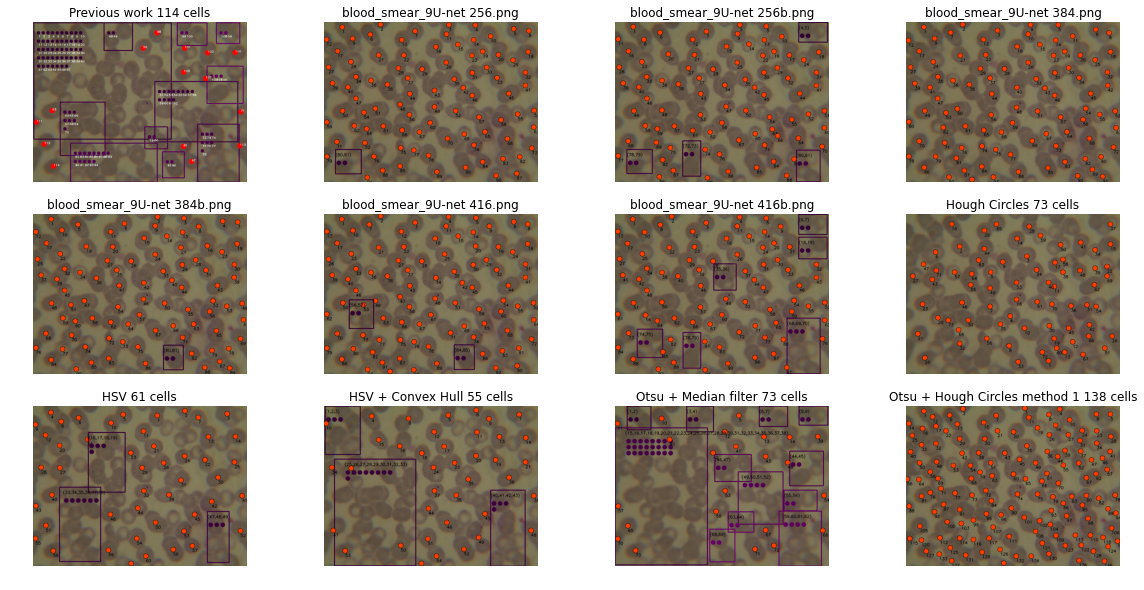

In [15]:
if __name__ == "__main__":
    
    oliv = cv2.imread("./segmented/oliveira/blood_smear_9.png")
    oliv = cv2.cvtColor(oliv, cv2.COLOR_RGB2BGR)


    files = os.listdir("./segmented/standalone/")

    images = [oliv]
    names  = ["Previous work 114 cells"]

    for file in files:
        if file == "blood_smear_9_yolov8.png":
            continue
        if "blood_smear_9" in file:
            img = cv2.imread("./segmented/standalone/%s" % file)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            images.append(img)
            names.append(file)




    names_repl = {"_hough.png":"Hough Circles 73 cells", "_hsv.png":"HSV 61 cells", "_hsv_hull.png":"HSV + Convex Hull 55 cells", "_otsu.png":"Otsu + Median filter 73 cells",
                 "1_break.png":"Otsu + Hough Circles method 1 138 cells", "2_merge.png":"Hough Circles method 2 89 cells", "otsu_out_blur.png":"Otsu 65 cells",
                 "_rcnn.png":"Mask R-CNN 89 cells", "_unet.png":"U-Net 94 cells", "_waterhshed.png":"Watershed 93 cells", "_yolov8-new.png":"Yolov8 79 cells"}

    for key in names_repl:
        for i in range(len(names)):
            name = names[i]
            if name.endswith(key):
                names[i] = names_repl[key]

    #fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(8,20))
    # row = 0
    # col = 0
    # for img, name in zip(images, names):
    #     ax[row][col].set_title(name)
    #     ax[row][col].imshow(img)

    #     col += 1
    #     if col == 2:
    #         row += 1
    #         col = 0
    # plt.show()


    fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(20,10))
    row = 0
    col = 0
    for img, name in zip(images, names):
        ax[row][col].set_title(name)
        ax[row][col].imshow(img)

        col += 1
        if col == 4:
            row += 1
            col = 0
    plt.show()